# PINNs for Black–Scholes equation

Bryce Li

## Black–Scholes equation

$$\frac{\partial V}{\partial t}+\frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}+r S \frac{\partial V}{\partial S}-r V=0$$

$\begin{aligned} & C(0, t)=0 \text { for all } t \\ & C(S, t) \rightarrow S-K \text { as } S \rightarrow \infty \\ & C(S, T)=\max \{S-K, 0\}\end{aligned}$

### Analytical solution
$$
\begin{gathered}
C=N\left(d_1\right) S_t-N\left(d_2\right) K e^{-r t} \\
\text { where } d_1=\frac{\ln \frac{S_t}{K}+\left(r+\frac{\sigma^2}{2}\right) t}{\sigma \sqrt{t}} \\
\text { and } d_2=d_1-\sigma \sqrt{t}
\end{gathered}
$$

### Verify BS formula

In [ ]:
from io import IncrementalNewlineDecoder
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
%matplotlib inline

In [2]:

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

In [3]:
S = torch.Tensor([80]).requires_grad_()
t = torch.Tensor([0]).requires_grad_()
sigma = torch.Tensor([0.3]).requires_grad_()
r = torch.Tensor([0.05]).requires_grad_()
K = torch.Tensor([70])
T = torch.Tensor([1])
t2m = T-t

d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m)/(sigma * torch.sqrt(t2m))
d2 = d1 - sigma * torch.sqrt(t2m)

In [4]:

N0 = lambda value: 0.5 * (1 + torch.erf((value/2**0.5))) #normal cdf
Nd1 = N0(d1)
Nd2 = N0(d2)
C = S* Nd1 - K* Nd2 *torch.exp(-r*t2m)
print("Option Price:", C.item())

Option Price: 17.014957427978516


In [5]:

dCdt = tgrad.grad(C, t, create_graph=True, only_inputs=True)[0]
dCdt

tensor([-5.8385], grad_fn=<NegBackward0>)

In [6]:

dCdS = tgrad.grad(C, S, create_graph=True, only_inputs=True)[0]
d2CdS2 = tgrad.grad(dCdS, S, create_graph=True, only_inputs=True)[0]
dCdvol = tgrad.grad(C, sigma, create_graph=True, only_inputs=True)[0]
dCdS,d2CdS2,dCdvol

(tensor([0.7769], grad_fn=<AddBackward0>),
 tensor([0.0124], grad_fn=<AddBackward0>),
 tensor([23.8776], grad_fn=<AddBackward0>))

In [7]:

dCdt.item() + ((0.5*sigma**2) * (S**2)*d2CdS2.item() )+ r*S*dCdS.item() - r*C

tensor([4.1723e-07], grad_fn=<SubBackward0>)

## PDE Modelling for European option

In [8]:

K = 40
r = 0.05
sigma = 0.15
T = 1
S_range = [0, 160]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
     

In [9]:

def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1)) #price
    return X, y

# get_diff_data(10)

In [10]:

def get_ivp_data(n):
    X = np.concatenate([np.ones((n, 1)), #all at expiry time
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)

    return X, y

# get_ivp_data(10)

In [11]:

def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))

    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)

    return X1, y1, X2, y2

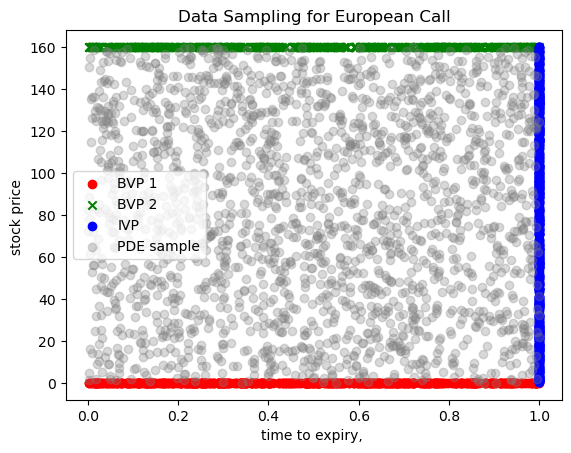

In [13]:

bvp_x1,bvp_y1,bvp_x2,bvp_y2 = get_bvp_data(500)
ivp_x1,ivp_y1 = get_ivp_data(500)
diff_x1,diff_y1 = get_diff_data(2000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.scatter(diff_x1[:,0],diff_x1[:,1], label= "PDE sample", color = "grey", alpha = 0.3)
plt.xlabel("time to expiry, ")
plt.ylabel("stock price ")
plt.title("Data Sampling for European Call")
plt.legend()

#### Construct NN

In [14]:

class european_call(nn.Module):
    "Defines a Phsyics informed network"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation1 = nn.LeakyReLU(negative_slope=0.1)
        activation2 = nn.Tanh()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation1])
        self.fch = nn.Sequential(*[nn.Sequential(*[
                            nn.BatchNorm1d(N_HIDDEN),
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation1]) for _ in range(N_LAYERS)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
     

In [68]:

model = european_call(2,1,100,8)
optimizer = torch.optim.Adam(model.parameters(),lr=7e-5)
print (f"Model parameters : {sum(p.numel() for p in model.parameters())/10**3:.2f}K")

Model parameters : 82.80K


In [69]:
print (model)

european_call(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (fch): Sequential(
    (0): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bi

#### Training config

In [70]:
N_sample = 500*3
physics_lr = 1000*5

loss_history={
    "total_loss":[],"loss1":[],"loss2":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}

for i in range(10000):
    optimizer.zero_grad()

    # Get IVP data
    ivp_x, ivp_y = get_ivp_data(N_sample)
    ivp_x_tensor = torch.from_numpy(ivp_x).float()
    ivp_y_tensor = torch.from_numpy(ivp_y).float()
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1, bvp_y1, bvp_x2, bvp_y2 = get_bvp_data(N_sample)
    bvp_x1_tensor = torch.from_numpy(bvp_x1).float()
    bvp_y1_tensor = torch.from_numpy(bvp_y1).float()
    bvp_x2_tensor = torch.from_numpy(bvp_x2).float()
    bvp_y2_tensor = torch.from_numpy(bvp_y2).float()
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y1_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1, y1 = get_diff_data(4*N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_()
    y1 = torch.from_numpy(y1).float()
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + 0.5 * ((sigma * S1) ** 2) * d2VdS2 + r * S1 * dVdS - r * y1_hat
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss1"].append(loss1.item())
    loss_history["loss2"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    loss.backward()
    optimizer.step()


    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.6f}")


Epoch 500, Loss: 17913.783203
Epoch 1000, Loss: 16314.106445
Epoch 1500, Loss: 11237.853516
Epoch 2000, Loss: 10492.849609
Epoch 2500, Loss: 9878.284180
Epoch 3000, Loss: 11769.652344
Epoch 3500, Loss: 12097.466797
Epoch 4000, Loss: 8680.306641
Epoch 4500, Loss: 8133.613281
Epoch 5000, Loss: 8145.077637
Epoch 5500, Loss: 8206.852539
Epoch 6000, Loss: 8193.027344
Epoch 6500, Loss: 7953.851562
Epoch 7000, Loss: 7898.727051
Epoch 7500, Loss: 7881.449219
Epoch 8000, Loss: 7670.339844
Epoch 8500, Loss: 7576.312012
Epoch 9000, Loss: 7679.746094
Epoch 9500, Loss: 7471.774902
Epoch 10000, Loss: 8188.118164


In [71]:

loss_df = pd.DataFrame.from_dict(loss_history)
# loss_df["loss"] = loss_history
# loss_df["ma_100_loss"] = loss_df["loss"].rolling(100).mean()
# ax = loss_df.plot(y='loss', logy=True)
# loss_df.plot(y='ma_100_loss', ax=ax)
# ax.set_ylabel("Log loss")

In [72]:

loss_df.head()

,total_loss,loss1,loss2,loss_bvp1,loss_bvp2,loss_ivp
0,25013.271484,18208.923828,6804.347168,0.071315,14602.325195,3606.528076
1,23114.152344,18215.445312,4898.708008,0.071126,14607.257812,3608.116455
2,22643.476562,18279.556641,4363.919434,0.077763,14597.740234,3681.739014
3,21967.775391,18215.449219,3752.325684,0.086146,14604.010742,3611.352295
4,21620.251953,18238.492188,3381.759766,0.087135,14600.490234,3637.914551


<Axes: >

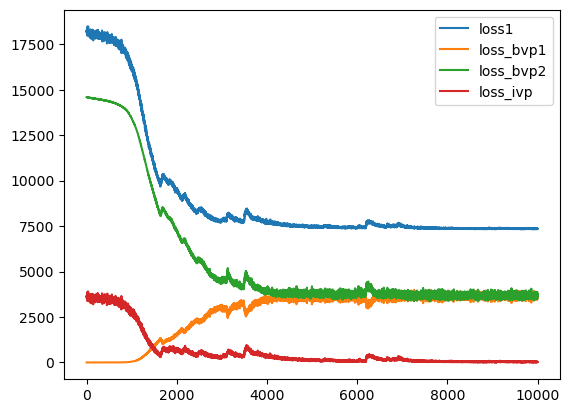

In [76]:

loss_df[["loss1","loss_bvp1","loss_bvp2","loss_ivp"]].plot()

#### Analytical solution V.S.  PINN solution

In [77]:

def eur_call_analytical_price(S, t, K, sigma):
    t2m = t  # Time to maturity (assumed in years)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m) / (sigma * torch.sqrt(t2m))
    d2 = d1 - sigma * torch.sqrt(t2m)
    # Normal cumulative distribution function (CDF)
    N0 = lambda value: 0.5 * (1 + torch.erf(value / (2**0.5)))
    Nd1 = N0(d1)
    Nd2 = N0(d2)
    # Calculate the option price
    C = S * Nd1 - K * Nd2 * torch.exp(-r * t2m)
    return C
     

In [78]:
eur_call_analytical_price(torch.tensor([80]),torch.tensor([1]),torch.tensor([70]), sigma =0.30)

tensor([17.0150])

In [79]:

s = np.linspace(S_range[0], S_range[1], 50)
t = np.linspace(t_range[0], t_range[1], 50)
s_grid, t_grid = np.meshgrid(s, t)

s_flat = s_grid.flatten()
t_flat = t_grid.flatten()

# Create a 2D tensor from the flattened arrays
X_test = torch.tensor(np.column_stack((t_flat, s_flat)), dtype=torch.float)

y_analytical_test = eur_call_analytical_price(X_test[:,1],X_test[:,0],torch.tensor([K]), sigma = sigma)
X_test.shape,y_analytical_test.shape

(torch.Size([2500, 2]), torch.Size([2500]))

In [80]:

with torch.no_grad():
  y_pinn_test = model(X_test)

Text(0.5, 1.0, 'European Call Option pricing')

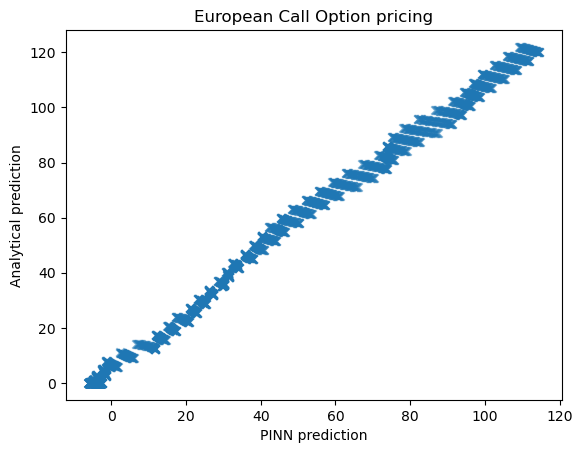

In [81]:

plt.scatter(x= y_pinn_test.detach().numpy(), y = y_analytical_test.detach().numpy(), marker = "x", alpha = 0.5)
plt.xlabel("PINN prediction")
plt.ylabel("Analytical prediction")
plt.title("European Call Option pricing")

In [82]:

y_pinn_test.detach().numpy().shape

(2500, 1)

In [83]:
np.corrcoef(y_pinn_test.detach().numpy().reshape(y_pinn_test.shape[0],),y_analytical_test.detach().numpy())

array([[1.        , 0.99796972],
       [0.99796972, 1.        ]])

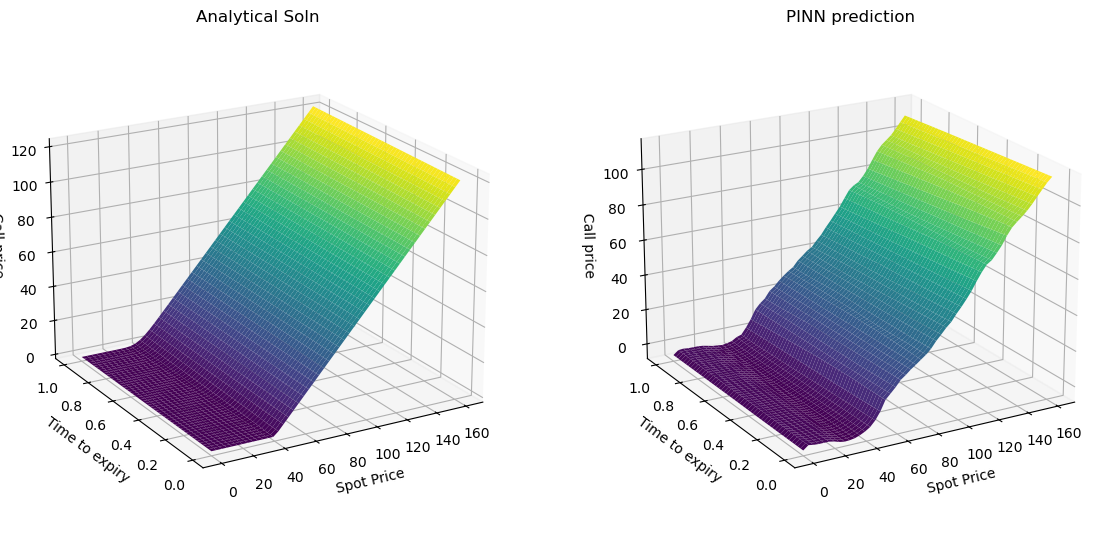

In [84]:

# Create the 3D plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(s_grid, t_grid, y_analytical_test.detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("Analytical Soln")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(s_grid, t_grid, y_pinn_test.detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("PINN prediction")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)

torch.Size([50, 2]) torch.Size([50])


Text(0.5, 1.0, 'Analytical vs PINN price for t = 0.75')

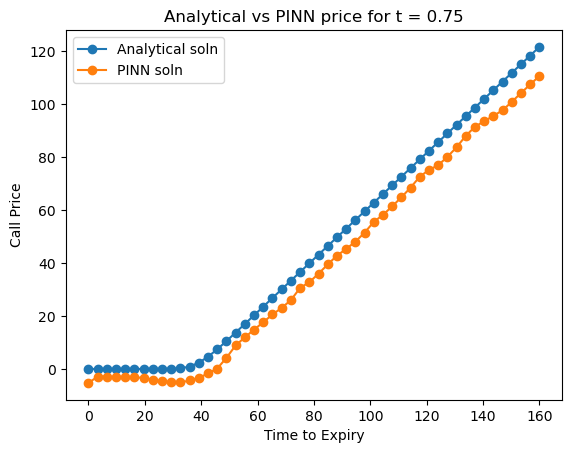

In [85]:

s1 = np.linspace(S_range[0], S_range[1], 50)
t1 = np.array([0.75]*s1.shape[0])

# Create a 2D tensor from the flattened arrays
X_test1 = torch.tensor(np.column_stack((t1, s1)), dtype=torch.float)

y_analytical_test1 = eur_call_analytical_price(X_test1[:,1],X_test1[:,0],torch.tensor([K]), sigma = sigma)
print(X_test1.shape,y_analytical_test1.shape)

with torch.no_grad():
  y_pinn_test1a = model(X_test1)

plt.plot(s1, y_analytical_test1.detach().numpy(), marker='o', linestyle='-', label="Analytical soln")
plt.plot(s1, y_pinn_test1a.detach().numpy().reshape(s1.shape), marker='o', linestyle='-', label="PINN soln")
plt.xlabel('Time to Expiry')
plt.ylabel('Call Price')
plt.legend()
plt.title("Analytical vs PINN price for t = 0.75")

torch.Size([50, 2]) torch.Size([50])


Text(0.5, 1.0, 'Analytical vs PINN price for t = 0.25')

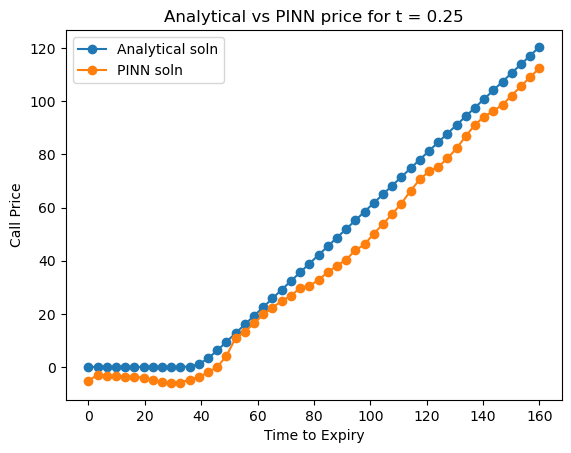

In [86]:

s1 = np.linspace(S_range[0], S_range[1], 50)
t1 = np.array([0.25]*s1.shape[0])

# Create a 2D tensor from the flattened arrays
X_test1 = torch.tensor(np.column_stack((t1, s1)), dtype=torch.float)

y_analytical_test1 = eur_call_analytical_price(X_test1[:,1],X_test1[:,0],torch.tensor([K]), sigma = sigma)
print(X_test1.shape,y_analytical_test1.shape)

with torch.no_grad():
  y_pinn_test1a = model(X_test1)

plt.plot(s1, y_analytical_test1.detach().numpy(), marker='o', linestyle='-', label="Analytical soln")
plt.plot(s1, y_pinn_test1a.detach().numpy().reshape(s1.shape), marker='o', linestyle='-', label="PINN soln")
plt.xlabel('Time to Expiry')
plt.ylabel('Call Price')
plt.legend()
plt.title("Analytical vs PINN price for t = 0.25")